In [14]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime as dt, date
from dateutil.relativedelta import relativedelta
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from impyute.imputation.cs import em
warnings.filterwarnings('ignore')
import requests
API_KEY = "ISRJKSC7ZGXSLEDI"

In [15]:
funda_data = pd.read_csv('Fundamental_data.csv')
flow_data = funda_data.loc[:,['public_date','pcf','PEG_trailing','TICKER']]
funda_data = funda_data.drop(columns=['qdate',"pcf",'staff_sale','PEG_trailing','gvkey','permno','adate'])
funda_data = funda_data.drop_duplicates()
stock_list = ['AAPL','AMZN','BRK-B','GOOG','JNJ','META','MSFT','NVDA','TSLA','V']

In [18]:
def get_daily_adjusted_prices(symbol):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&outputsize=full&apikey={API_KEY}'
    
    r = requests.get(url)
    #data_adjusted = r.json()
    data = r.json()
  
    if   r.status_code==200:
       
        #price_data_adj = data_adjusted["Time Series (Daily)"]
        price_data = data["Time Series (Daily)"]
        price_df = pd.DataFrame(price_data).transpose().reset_index()
        price_df.rename(columns={'index':'Date'},inplace=True)
        #price_df_adj = pd.DataFrame(price_data_adj).reset_index()
        #price_df_adj.rename(columns={'index':'Date'},inplace=True)
        #price_df = price_df.merge(price_df_adj.loc[:,["Date","5. adjusted close"]], on='Date',how='left')
        price_df.loc[:,'Date'] = [dt.strptime(d,'%Y-%m-%d') for d in price_df.Date]
        end_date = dt(2020,2,1)
        start_date = dt(2010,1,1)
        price_df = price_df.loc[(price_df.Date>=start_date)&(price_df.Date<=end_date),:].reset_index(drop=True)
        return price_df
    else: return None

def get_monthly_adjusted_prices(symbol):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol={symbol}&outputsize=full&apikey={API_KEY}'
    
    r = requests.get(url)
    data = r.json()
  
    if   r.status_code==200:
        price_data = data["Monthly Adjusted Time Series"]
        price_df = pd.DataFrame(price_data).transpose().reset_index()
        price_df.rename(columns={'index':'Date'},inplace=True)

        price_df.loc[:,'Date'] = [dt.strptime(d,'%Y-%m-%d') for d in price_df.Date]
        end_date = dt(2020,2,1)
        start_date = dt(2010,1,1)
        price_df = price_df.loc[(price_df.Date>=start_date)&(price_df.Date<=end_date),:].reset_index(drop=True)
        return price_df
    else: return None

def get_weekly_adjusted_prices(symbol):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY_ADJUSTED&symbol={symbol}&outputsize=full&apikey={API_KEY}'
    
    r = requests.get(url)
    data = r.json()
  
    if   r.status_code==200:
        price_data = data["Weekly Adjusted Time Series"]
        price_df = pd.DataFrame(price_data).transpose().reset_index()
        price_df.rename(columns={'index':'Date'},inplace=True)

        price_df.loc[:,'Date'] = [dt.strptime(d,'%Y-%m-%d') for d in price_df.Date]
        end_date = dt(2020,2,1)
        start_date = dt(2010,1,1)
        price_df = price_df.loc[(price_df.Date>=start_date)&(price_df.Date<=end_date),:].reset_index(drop=True)
        return price_df
    else: return None

In [21]:
SPY_daily = get_daily_adjusted_prices('SPY')[['Date','5. adjusted close']]
SPY_weekly = get_weekly_adjusted_prices('SPY')[['Date','5. adjusted close']]
SPY_monthly = get_monthly_adjusted_prices('SPY')[['Date','5. adjusted close']]
NADQ_daily = get_daily_adjusted_prices('ndaq')[['Date','5. adjusted close']]
NADQ_weekly = get_weekly_adjusted_prices('ndaq')[['Date','5. adjusted close']]
NADQ_monthly = get_monthly_adjusted_prices('ndaq')[['Date','5. adjusted close']]

In [37]:
def merge_left(funda_stock,name,flow_data,SPY,NADQ,freq):
    price = pd.read_csv('../encode_price/'+freq+'/'+name+'.csv')
    price['Date'] = price.Date.apply(lambda x: dt.strptime(x,'%Y-%m-%d'))
    close = price.loc[:,['Date']]
    funda_stock = pd.merge(flow_data,funda_stock,how='outer',on = ['public_date'])
    index_data = pd.merge(SPY,NADQ,how='outer',on=['Date'])
    index_data.rename(columns={'5. adjusted close_x':'SPY','5. adjusted close_y':'NADQ'},inplace=True)
    df = pd.merge(funda_stock,close,how='right',left_on=['public_date'],right_on=['Date'])
    df = pd.merge(df,index_data,how='left',on='Date')
    df['SPY'] = df.SPY.apply(lambda x: float(x))
    df['NADQ'] = df.NADQ.apply(lambda x: float(x))
# Here we merge the dataset together using the forward filling method, which is using the old time data to fill the later time.
    df.set_index('Date',inplace=True)
    df.drop(columns=['TICKER_x','TICKER_y','public_date'],inplace=True)
    newdf = pd.DataFrame(em(df.values,loops=1000),columns=df.columns,index=df.index)
    newdf.to_csv('FundaIndicators/'+freq+'/'+name+'.csv')

In [38]:
for name in pd.unique(funda_data.TICKER).tolist():
    funda_stock = funda_data.loc[funda_data.TICKER==name,:]
    funda_stock['public_date'] = funda_data.public_date.apply(lambda x:dt.strptime(x,'%m/%d/%Y'))
    flow_stock = flow_data.loc[flow_data.TICKER==name,:]
    flow_stock['public_date'] = flow_stock.public_date.apply(lambda x:dt.strptime(x,'%m/%d/%Y'))
    if name == 'FB':
        name = 'META'
    elif name == 'BRK':
        name = 'BRK-B'
    elif name == 'GOOGL':
        name = 'GOOG'
    merge_left(funda_stock,name,flow_stock,SPY_daily,NADQ_daily,'Daily')
    merge_left(funda_stock,name,flow_stock,SPY_weekly,NADQ_weekly,'Weekly')
    merge_left(funda_stock,name,flow_stock,SPY_monthly,NADQ_monthly,'Monthly')
    print(name)

MSFT
META
AAPL
BRK-B
JNJ
AMZN
NVDA
GOOG
GOOG
V
TSLA


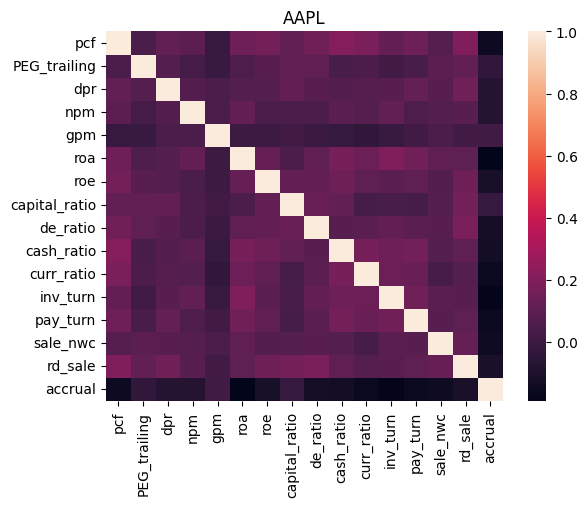

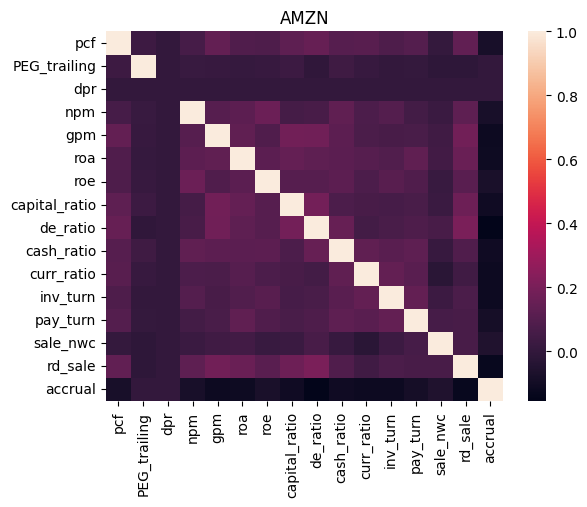

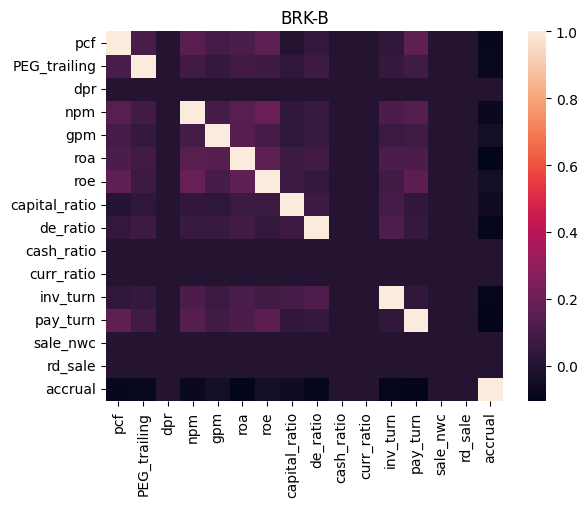

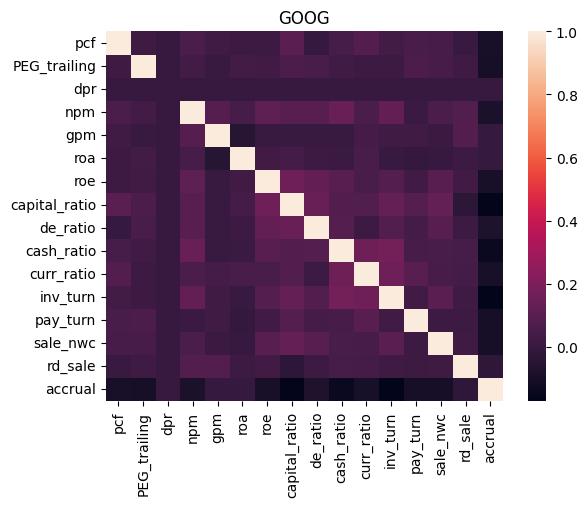

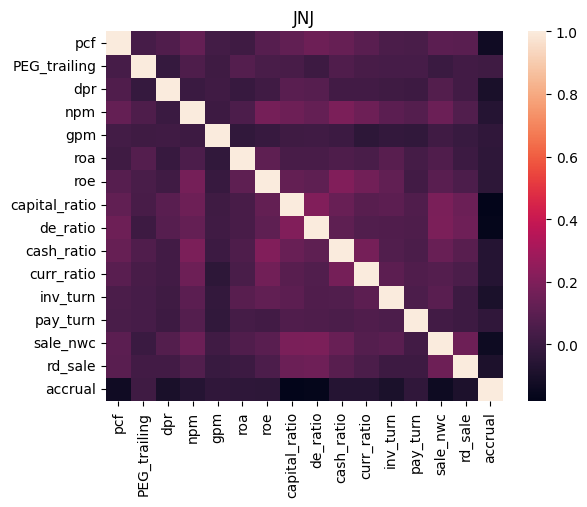

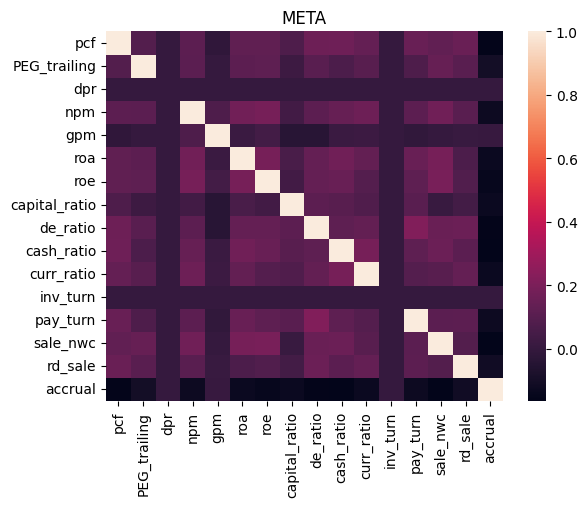

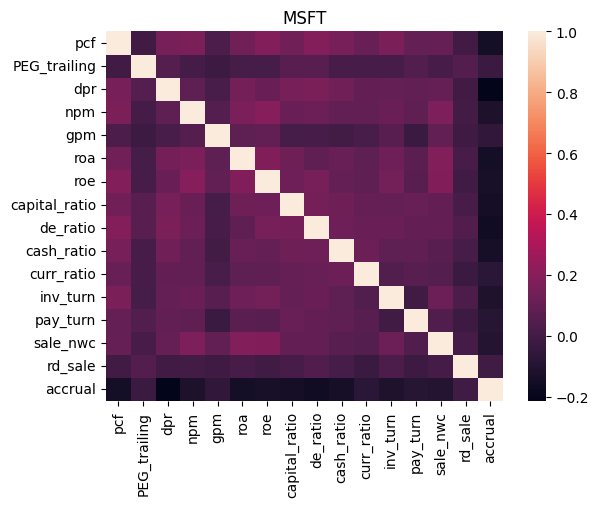

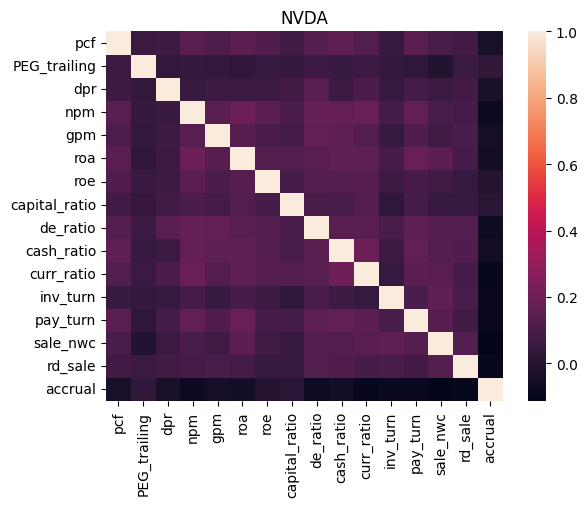

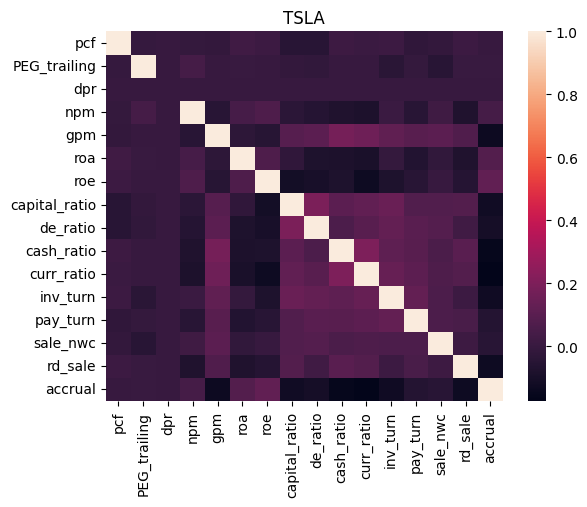

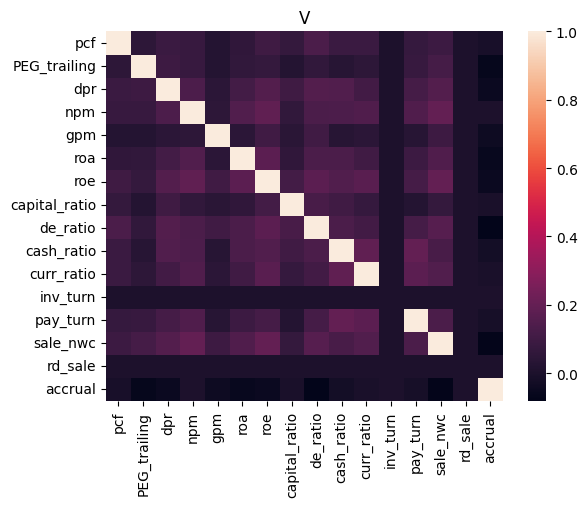

In [5]:
freq = 'Daily'

for name in stock_list:
    FundaInd = pd.read_csv('FundaIndicators/'+freq+'/'+name+'.csv')
    sns.heatmap(FundaInd.corr().fillna(0))
    plt.title(name)
    plt.show()

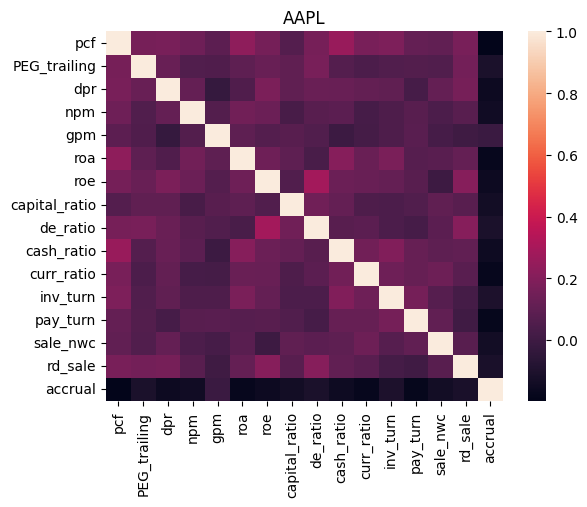

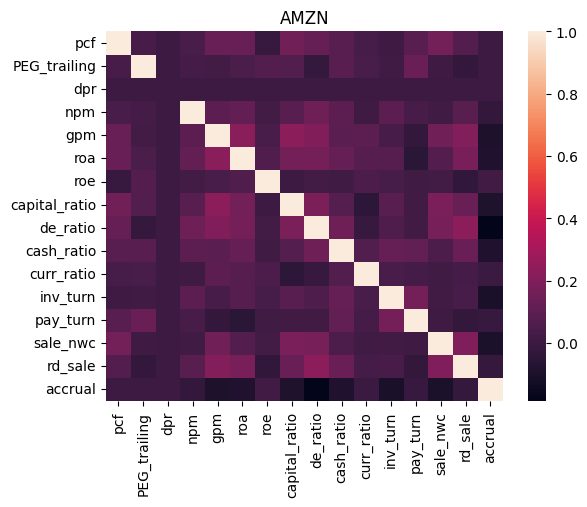

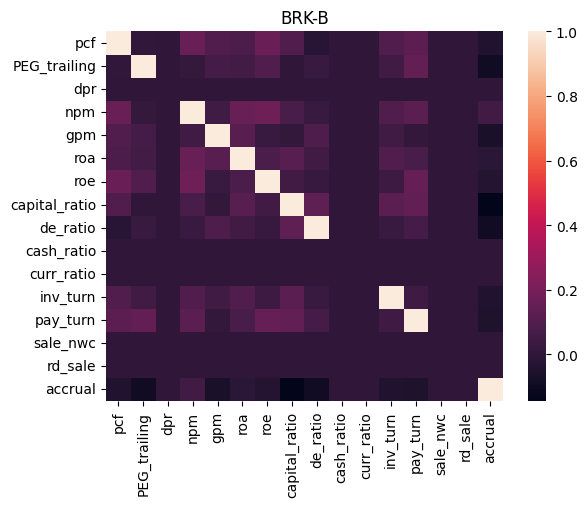

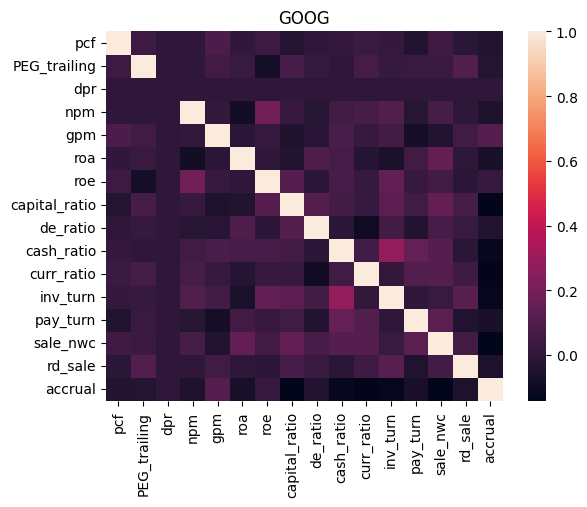

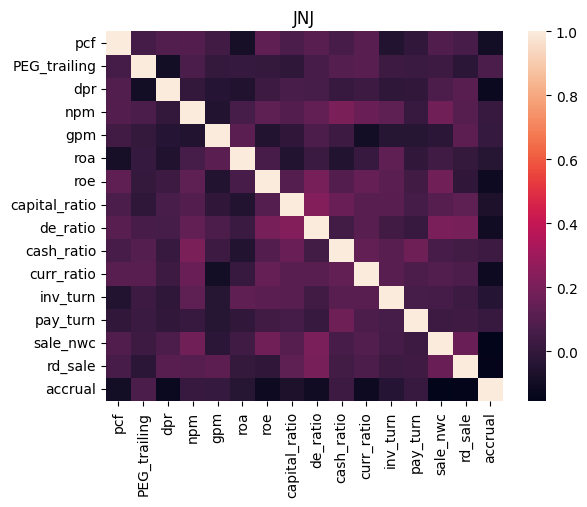

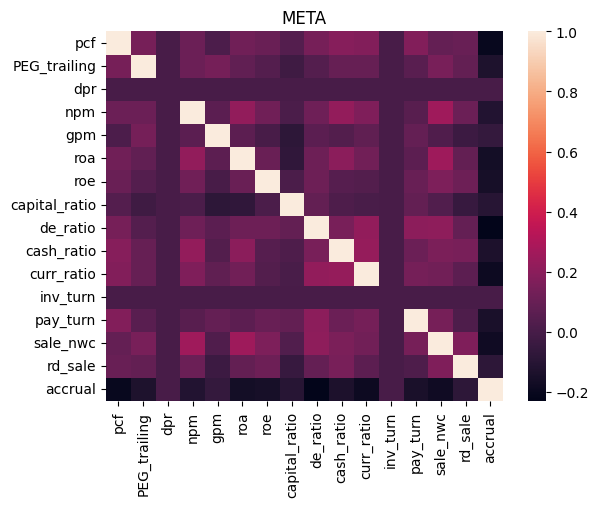

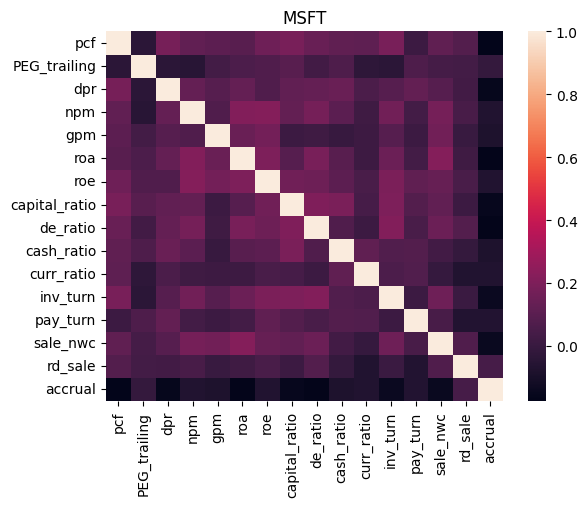

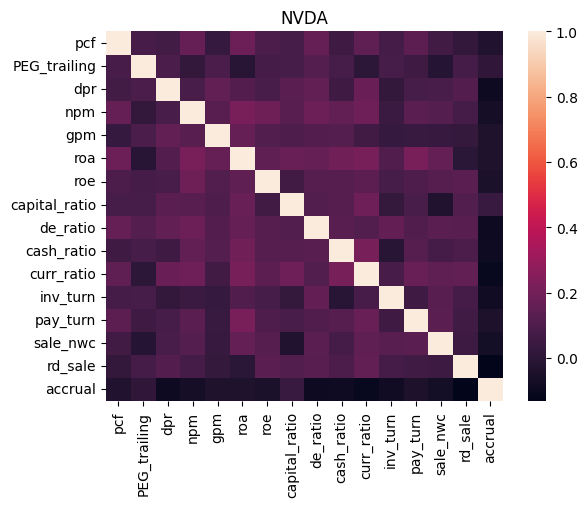

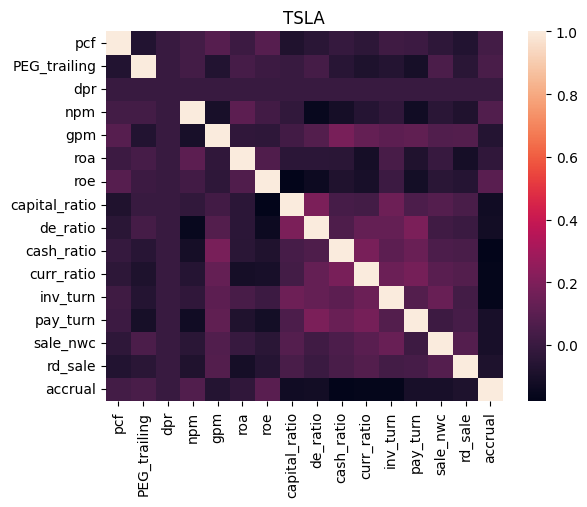

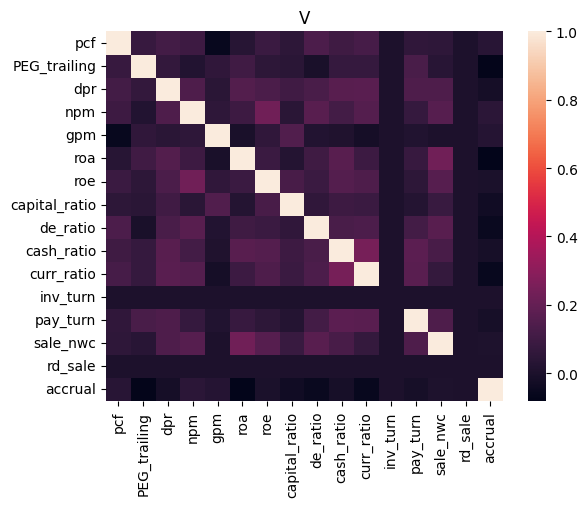

In [6]:
freq = 'Weekly'

for name in stock_list:
    FundaInd = pd.read_csv('FundaIndicators/'+freq+'/'+name+'.csv')
    sns.heatmap(FundaInd.corr().fillna(0))
    plt.title(name)
    plt.show()

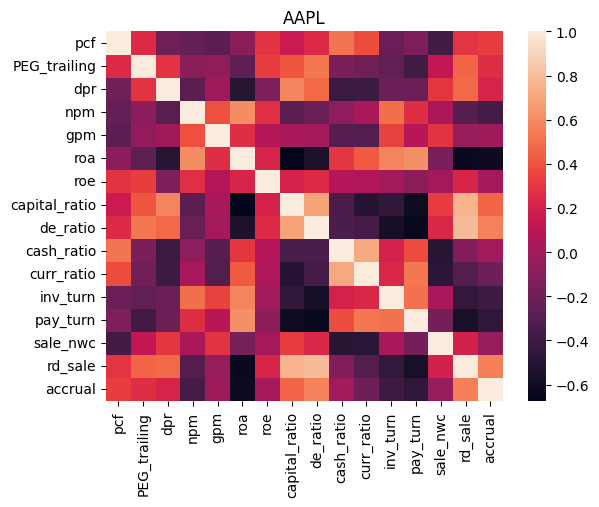

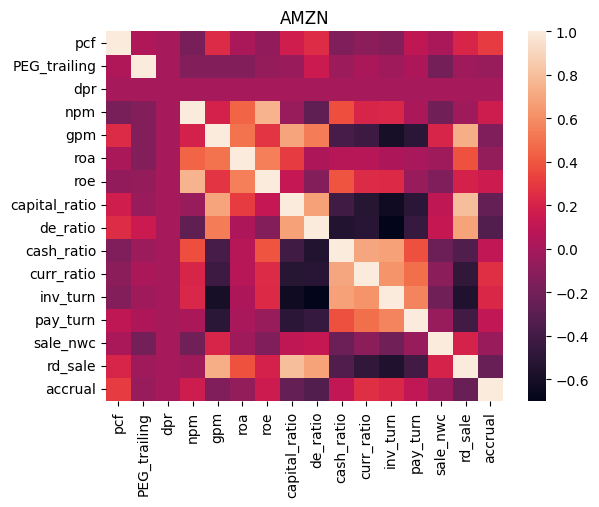

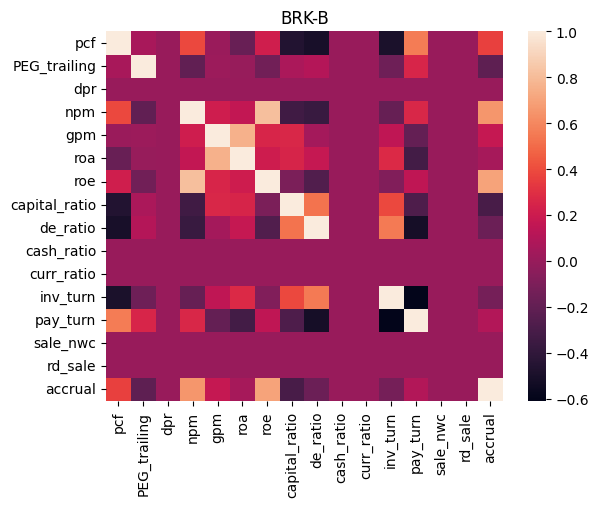

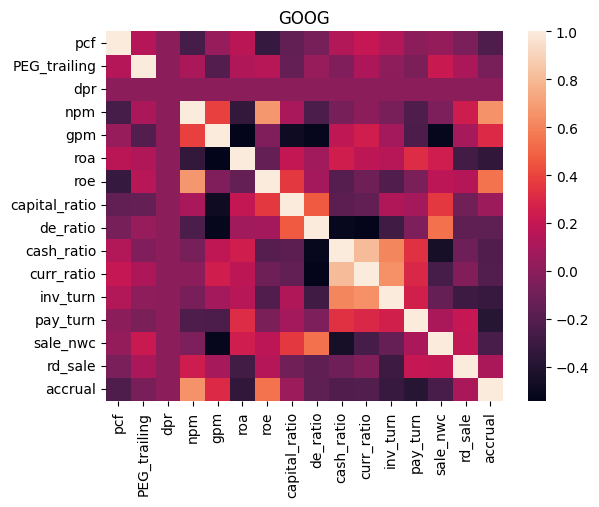

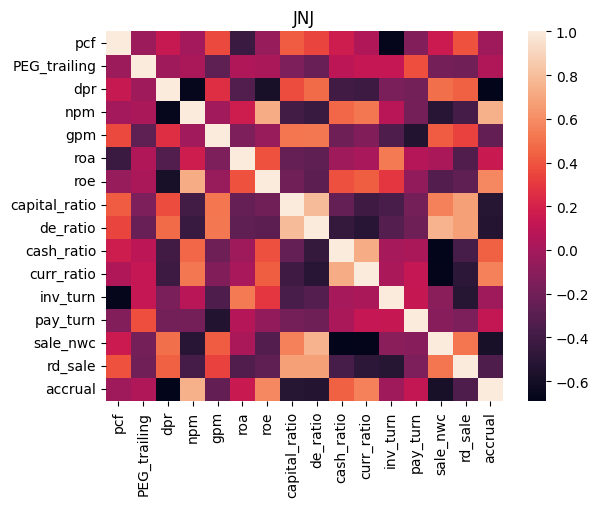

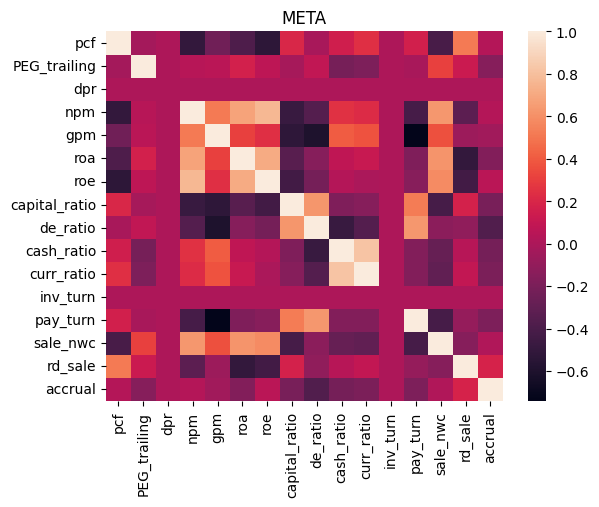

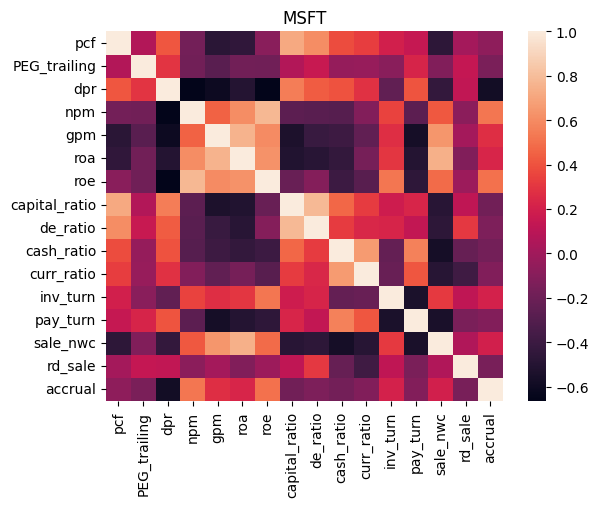

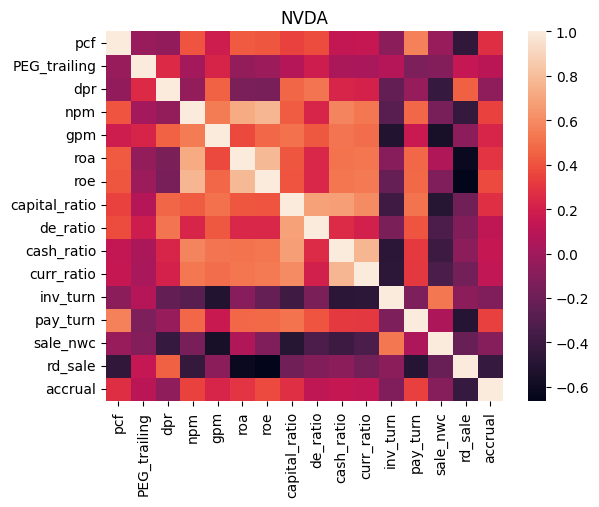

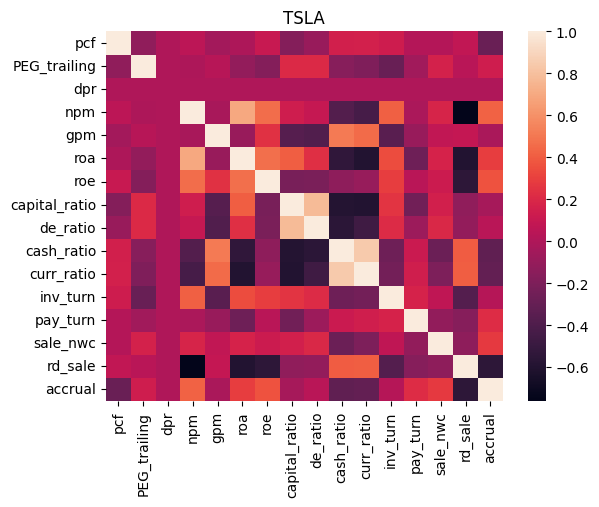

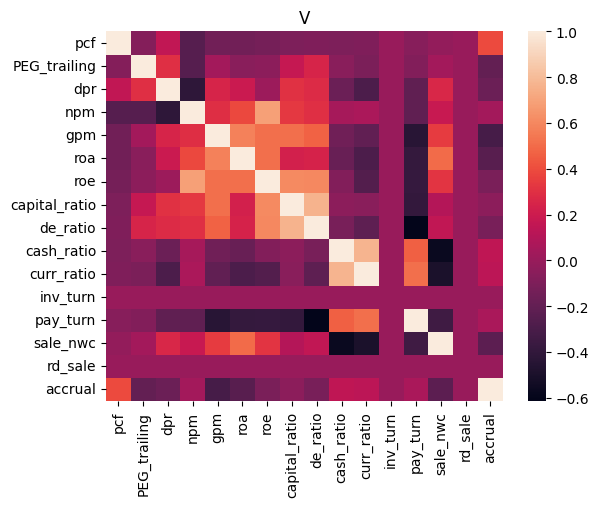

In [7]:
freq = 'Monthly'

for name in stock_list:
    FundaInd = pd.read_csv('FundaIndicators/'+freq+'/'+name+'.csv')
    sns.heatmap(FundaInd.corr().fillna(0))
    plt.title(name)
    plt.show()

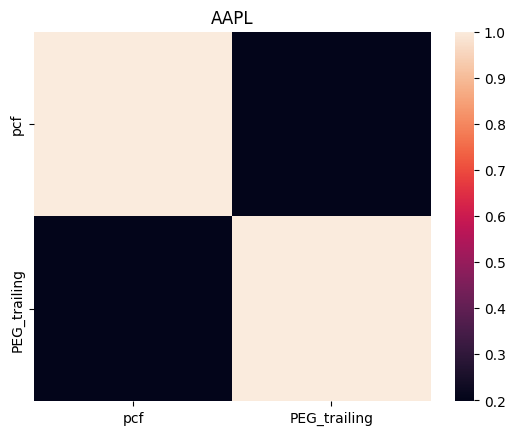

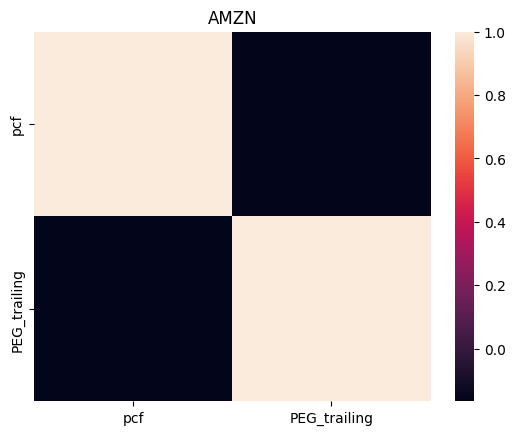

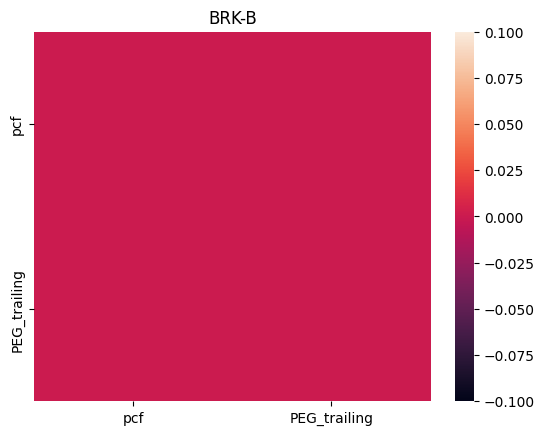

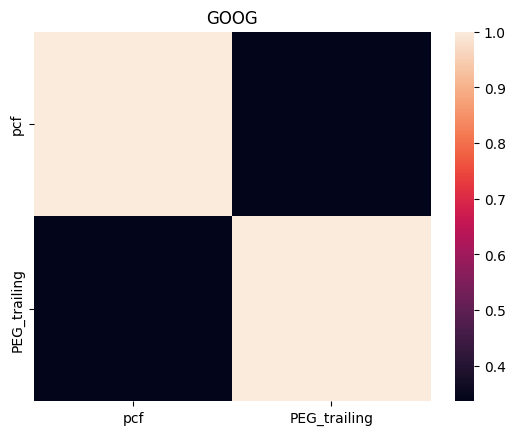

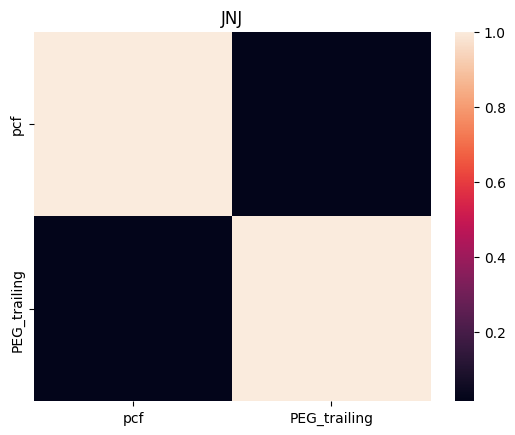

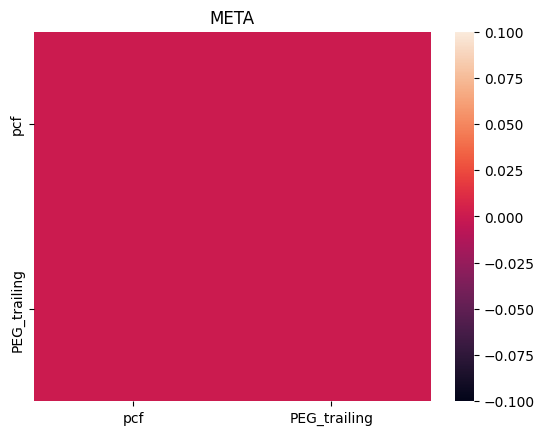

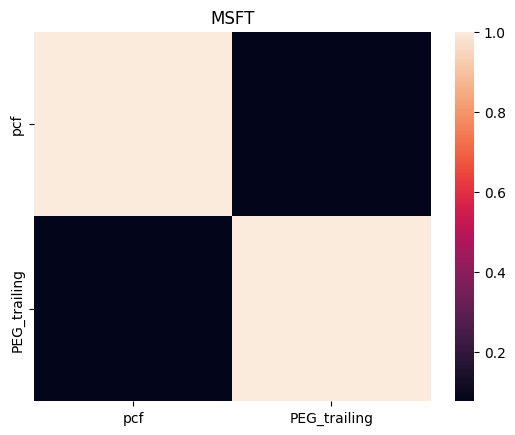

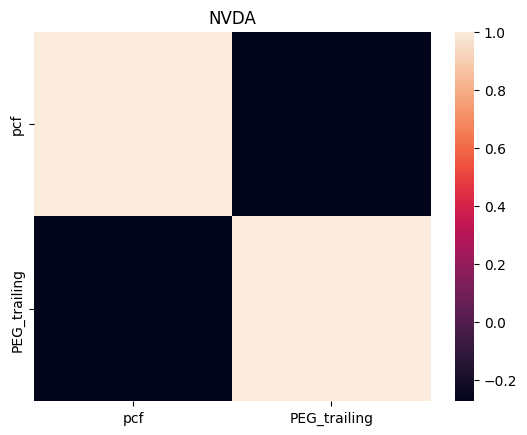

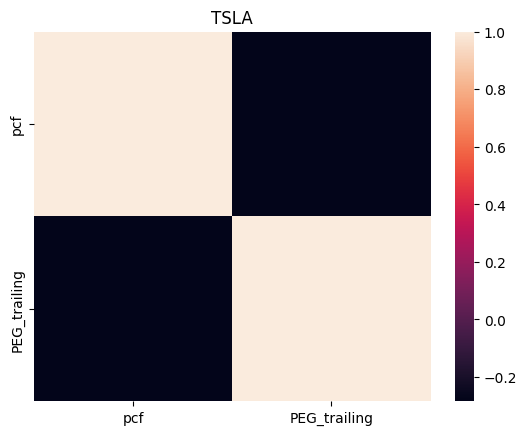

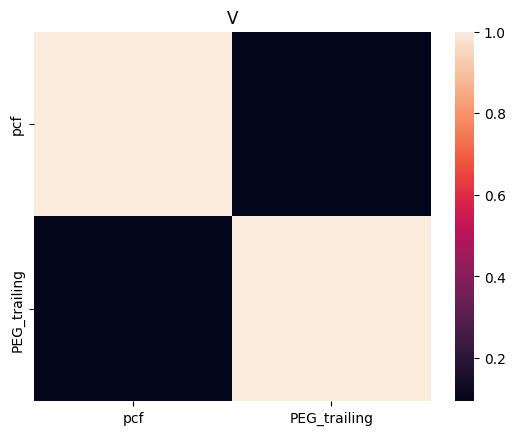

In [8]:
for s in stock_list:
    flow_stock = flow_data.loc[flow_data.TICKER == s,:]
    flow_stock['public_date'] = flow_stock.public_date.apply(lambda x:dt.datetime.strptime(x,'%m/%d/%Y'))
    flow_stock.set_index('public_date')
    sns.heatmap(flow_stock.corr().fillna(0))
    plt.title(s)
    plt.show()

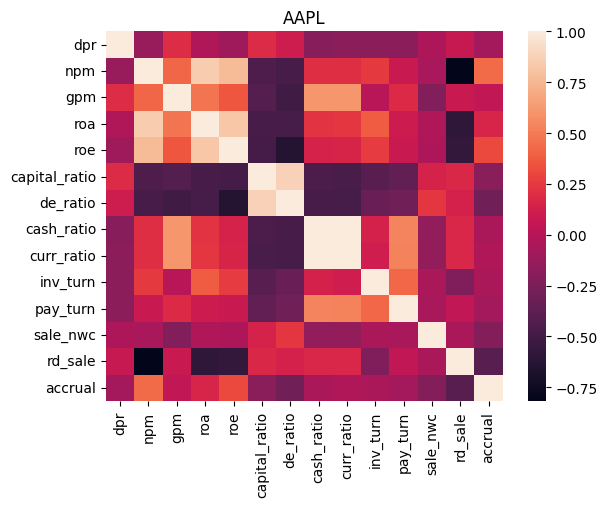

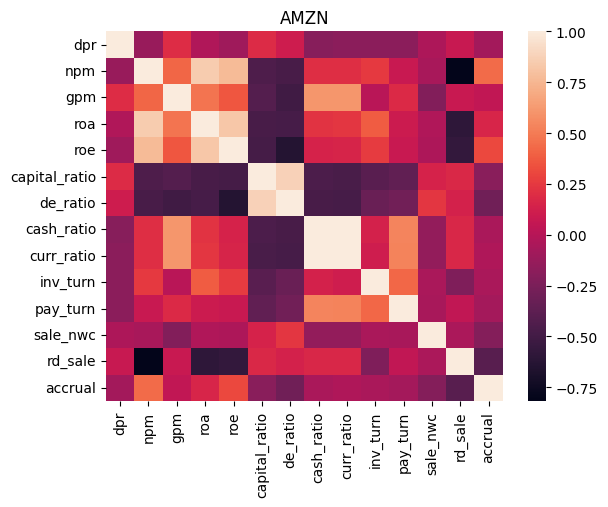

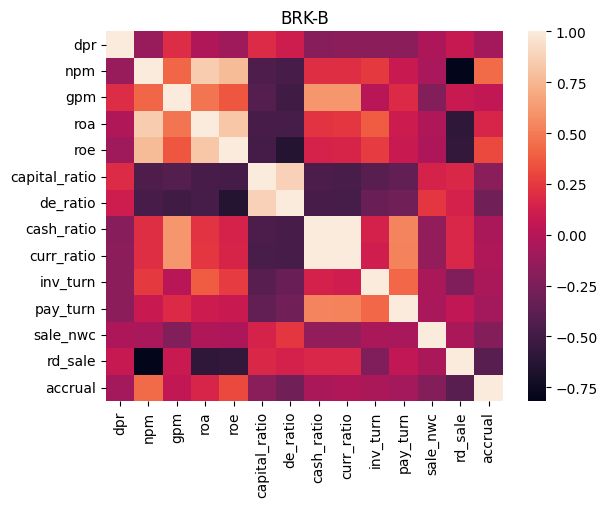

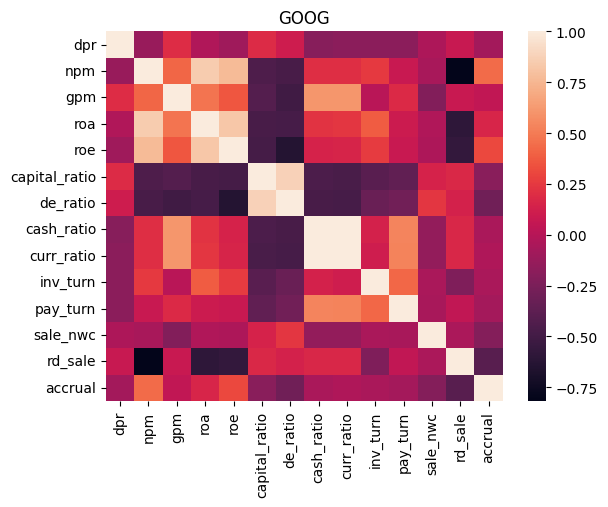

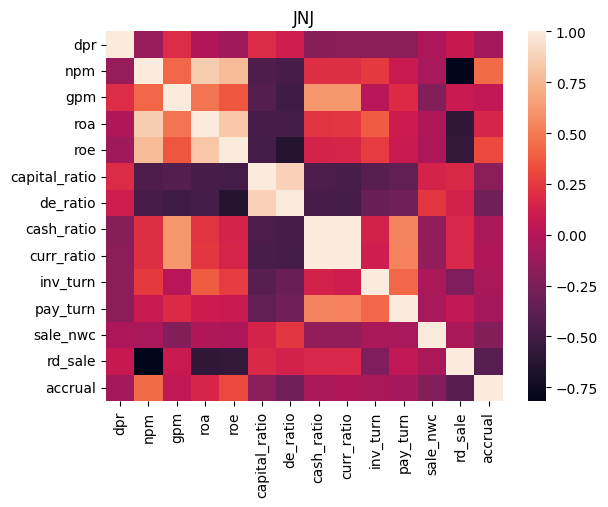

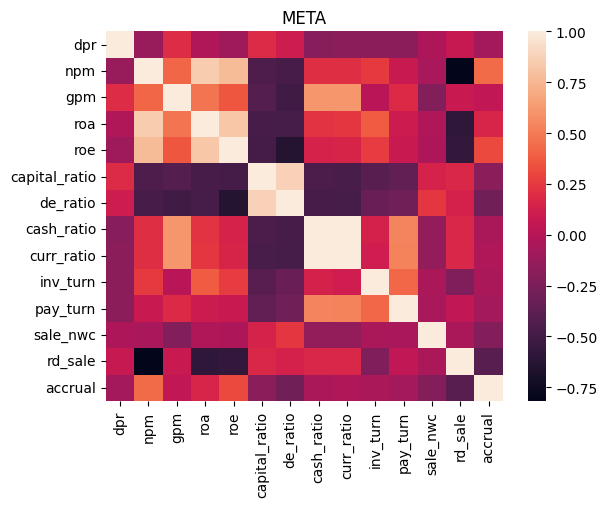

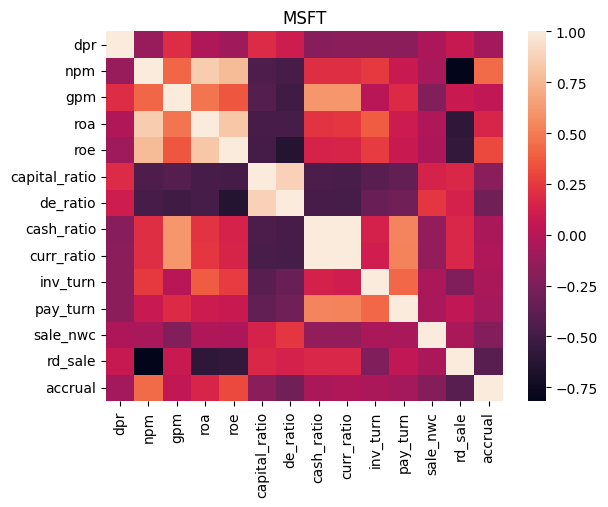

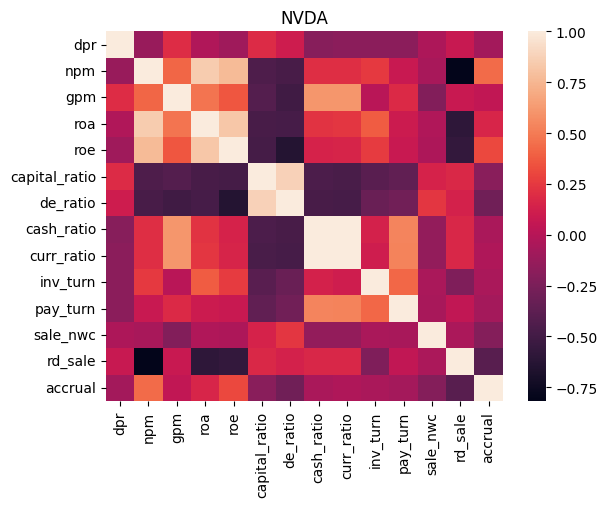

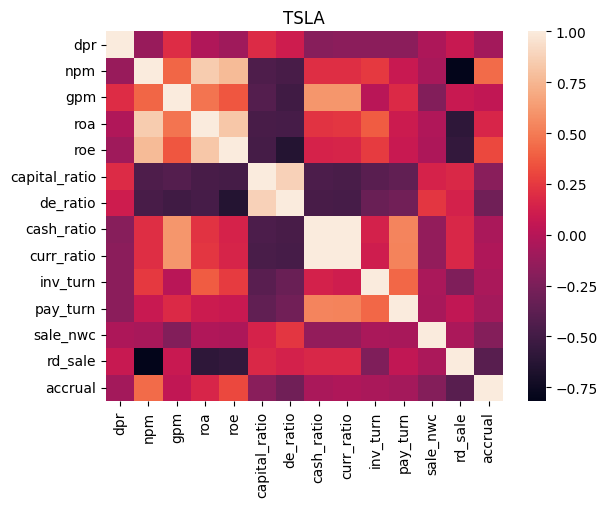

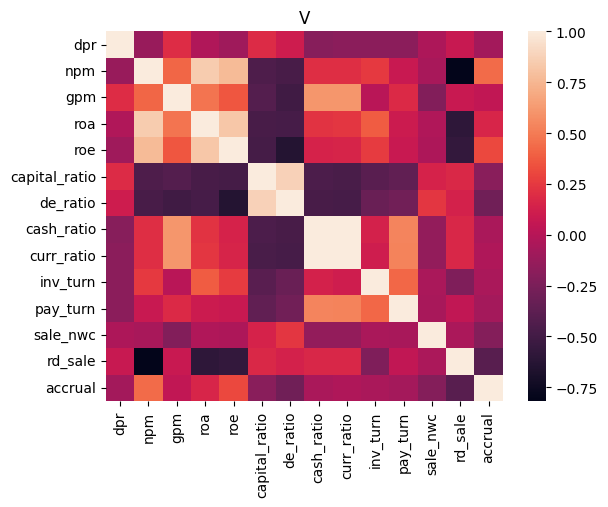

In [9]:
for s in stock_list:
    funda_stock = funda_data.loc[funda_data.TICKER == s,:]
    funda_stock['public_date'] = funda_data.public_date.apply(lambda x:dt.datetime.strptime(x,'%m/%d/%Y'))
    funda_stock.set_index('public_date')
    sns.heatmap(funda_data.corr().fillna(0))
    plt.title(s)
    plt.show()